# Setup

In this example, as in others, we will be running our examples on the covasim package. This code assumes that the notebook sits within the Covasim repository.

For your work you will be running this on your own code, so any calls to CovaSim will need to be replaced with calls to suitable entry-points within your own system.

The nice thing here is that we are not relying on scrutinising the source code itself. You can install (via ```pip install```) the project you are interested in analysing. This is what we do here.

One major caveat is that the version you analyse *must* correspond to the version you are using for the rest of your analyses (e.g. for static analysis). If the version you install via pip is different, then you will get inconsistent results.


This is our setup code. We'll be offering four types of dynamic analysis, as defined in the Outputs class.

In [21]:
#Start by installing the external projects we will need for this.

%pip install covasim graphviz pandas plotly networkx matplotlib

  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b899f6b19f61f70/networkx-3.2.1-py3-none-any.whl.metadata
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from enum import Enum

class Outputs(Enum):
  CALLS = 1 #Call graph, stored as a dot graph.
  LINES = 2 #Record every single line encountered as a list.
  PHASES = 3 #Record the stack depth at each method call, store as CSV.

class PhaseData(Enum):
  STACK_DEPTH = 1 #Call stack depth at every line.
  MEM_USAGE = 2 #Memory usage at every line

config = {"outputType":Outputs.CALLS,
          "phaseType":PhaseData.STACK_DEPTH,
          "fileNameFilter":"covasim"}



## Tracer code

The following block contains the actual tracer code. trace_calls is the actual function that we attach to the tracer, so this is called every time a traceable event is encountered.

It is worth pointing out how succinct and customisable this is. You can get the tracer to store any of the data in whichever way you want, in the space of a couple of small functions. 

In [18]:
import sys
import os
import inspect
import sysconfig
import psutil

#These data structures will contain the trace data at any given point.
#Important that these are reset before every fresh trace!

#If building a call graph, this is stored as a dictionary, where the key 
#is a function, and the value is a list of destination functions.
trace = {}

#Lines are stored as a list, if tracer is activated in Line-tracing mode
lines = []

phases = []



def is_system_code(filename):
    """Check if the filename belongs to system or third-party libraries."""
    return (
        not config["fileNameFilter"] in filename
    )


def reset():
    trace.clear()
    lines.clear()
    phases.clear()
    
#Utility function to store calls. Key is source method, value is a set of target methods.
def add_to_set(trace, key, value):
  if key not in trace:
    trace[key] = set()
  trace[key].add(value)
  return trace


def trace_lines(frame, event, arg):
    """
    Called for every line.
    """
    if event == 'line':
        co = frame.f_code
        func_filename = os.path.basename(co.co_filename)
        if not config["fileNameFilter"] in co.co_filename:
            return
        func_name = co.co_name
        line_no = frame.f_lineno
        key = func_filename+"."+func_name+":"+str(line_no)
        if config["outputType"]==Outputs.LINES:
            lines.append(key)

def phase_data():
    if config["phaseType"] == PhaseData.STACK_DEPTH:
        return len(inspect.stack())
    process = psutil.Process(os.getpid())
    if config["phaseType"] == PhaseData.MEM_USAGE:
        return process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB

def trace_calls(frame, event, arg):
    if event != 'call':
        return
    co = frame.f_code
    func_filename = os.path.abspath(co.co_filename)  # Absolute path

    # Exclude system libraries and third-party packages
    if is_system_code(func_filename):
        return

    if not config["fileNameFilter"] in func_filename:
        return

    caller = frame.f_back
    caller_func = caller.f_code.co_name
    caller_filename = os.path.basename(caller.f_code.co_filename)
    key = caller_filename + "." + caller_func
    value = os.path.basename(func_filename) + "." + co.co_name
    if config["outputType"]==Outputs.PHASES:
        to_write = phase_data()
        phases.append((key,to_write))
    elif  config["outputType"]==Outputs.CALLS:
        add_to_set(trace, key, value)
    return trace_lines



# Tracing CovaSim

## Tracing each line

The following block shows how the tracer can be attached to a piece of code. Here we run our CovaSim case study system. This code will record each line executed, and add it to array lines[].

In [ ]:
import covasim as cv

reset() #Make sure that all of our data-structures for recording trace events are empty.

config["outputType"] = Outputs.LINES

#Set up the system we want to trace.
sim = cv.Sim()

#Attach the "trace_calls" method defined in the previous block to the system.
sys.settrace(trace_calls)

#Run the system we want to trace.
sim.run()

#Detatch the tracer after the execution is complete.
sys.settrace(None)

How big do you reckon the trace is? How many times was a line execution recorded?

In [ ]:
#Approximate runtime: 583ms
print("number of lines: ",len(lines))

reset()

## Building a Call graph

Now we repeat the above exercise, but instead of recording each line, we record each call.

In [19]:
import covasim as cv


reset()

# We can choose any of our four types of output - here we choose a CSV file.
config["outputType"] = Outputs.CALLS

#Set up the system we want to trace.
sim = cv.Sim()

#Attach the "trace_calls" method defined in the previous block to the system.
sys.settrace(trace_calls)

#Run the system we want to trace.
sim.run()

#Detatch the tracer after the execution is complete.
sys.settrace(None)

Initializing sim with 20000 people for 60 days
  Running 2020-03-01 ( 0/60) (0.21 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.26 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.31 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.36 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.42 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (0.50 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (0.60 s)  •••••••••••••••••••• 100%

Simulation summary:
       12,730 cumulative infections
          596 cumulative reinfections
       10,182 cumulative infectious
        6,395 cumulative symptomatic cases
          386 cumulative severe cases
          114 cumulative critical cases
        5,159 cumulative recoveries
           14 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated peo

## Visualising the call graph

### As a DOT graph

Our calls are recorded as a dictionary, where keys are functions, and values are lists of functions to which calls have been recorded.
We can easily build these as a GraphViz graph using the Python GraphViz library.

This requires GraphViz to be installed on your local path.

In [ ]:
import graphviz

def build_graph():
    graph = graphviz.Digraph(format="png")



    for(key,value) in trace.items():
        for v in value:
            if ".py" in key and ".py" in v:
                graph.edge(f'"{key}"',f'"{v}"')

    return graph


try:

    graph = build_graph()

    # Display in Jupyter Notebook
    display(graph)

     # Save as PDF
    output_filename = "callgraph"
    graph.render(output_filename, format="pdf", cleanup=True)
    print(f"Graph saved as {output_filename}.pdf")

except ValueError as e:
    print(e)

### As a graph using NetworkX and matplotlib

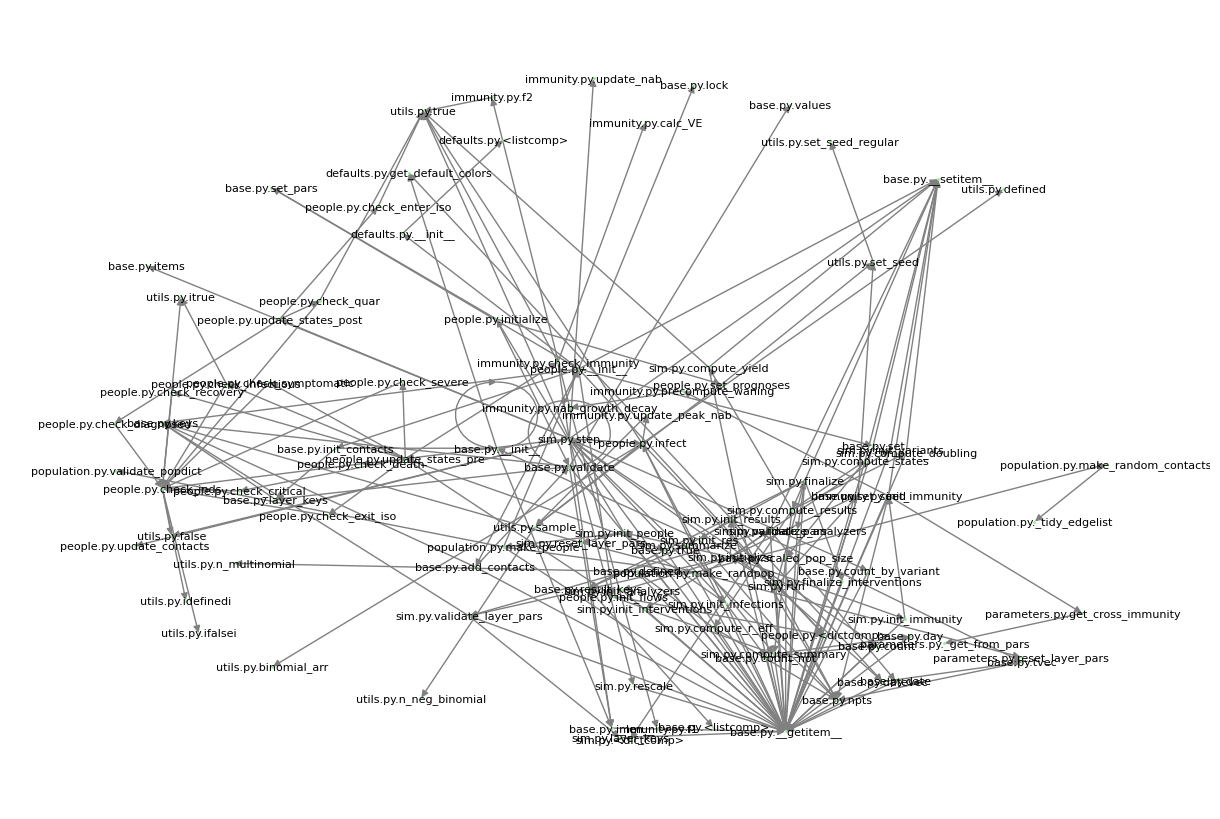

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

def build_call_graph(trace):
    G = nx.DiGraph()  # Create a directed graph

    for caller, callees in trace.items():
        for callee in callees:
            G.add_edge(caller, callee)  # Add directed edge

    return G

# Example: Convert trace to a graph
G = build_call_graph(trace)

# Draw the graph
plt.figure(figsize=(12, 8))
#pos = nx.circular_layout(G)
pos = nx.spring_layout(G, k=0.3)
#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', font_size=8, node_size=1)
plt.show()

## Focussing only on calls between classes

The graph created previously focusses on method-to-method calls. However, sometimes, especially for Reengineering, we are interested in the relationship between classes. Which classes are especially "close" to each other. Which pairs of classes might exhibit "feature envy"? In this graph we take exactly the same call data as above, but restrict nodes to the classes containing the methods, instead of the individual methods themselves.

This generates a different html file (in the root directory of your repository) that you can open in a web browser. To see and open the file, you may need to right-click on the "week5" directory in PyCharm, and click "reload from disk" to update the contents.

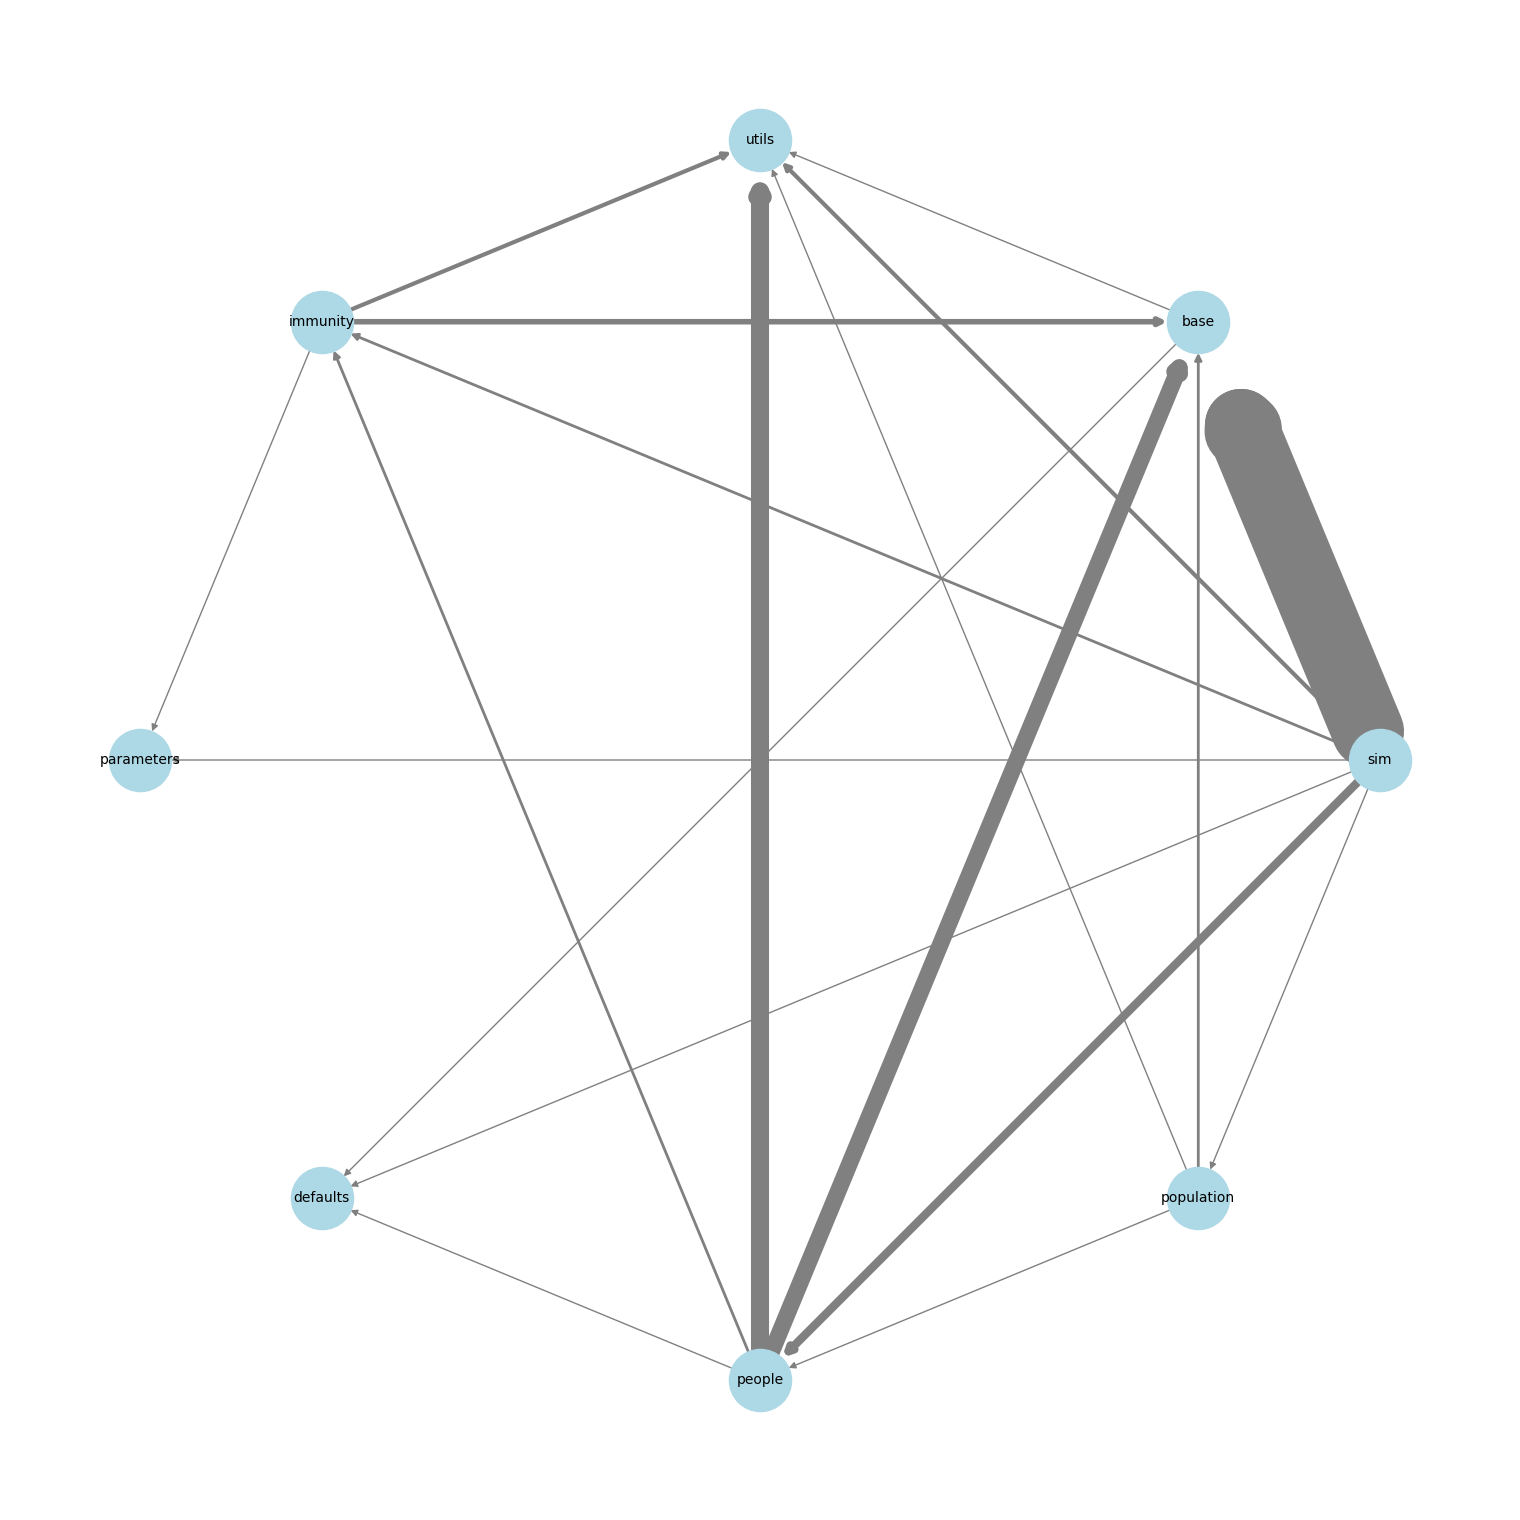

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

def merge_nodes_by_prefix(trace):
    G = nx.DiGraph()  # Create a directed graph
    node_mapping = {}  # Maps full node names to their merged "x" component
    edge_weights = {}  # Stores edge weights (number of calls)

    def get_prefix(name):
        return name.split(".")[0]  # Extract only the 'x' part

    # Step 1: Map all nodes to their merged group and count edges
    for caller, callees in trace.items():
        caller_group = get_prefix(caller)
        node_mapping[caller] = caller_group  # Store mapped value

        for callee in callees:
            callee_group = get_prefix(callee)
            node_mapping[callee] = callee_group
            if callee_group == caller_group:
                continue
            # Count occurrences of edges
            edge = (caller_group, callee_group)
            edge_weights[edge] = edge_weights.get(edge, 0) + 0.5

    # Step 2: Add merged edges to the graph
    for (src, dst), weight in edge_weights.items():
        G.add_edge(src, dst, weight=weight)  # Store weight in edge attributes

    return G, edge_weights

# Example: Convert trace to a grouped call graph
ClassGraph, edge_weights = merge_nodes_by_prefix(trace)

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.circular_layout(ClassGraph)

# Extract edge weights for visualization
edge_widths = [edge_weights[edge] * 2 for edge in ClassGraph.edges()]  # Scale thickness

nx.draw(ClassGraph, pos, with_labels=True, node_color='lightblue', edge_color='gray',
        font_size=10, node_size=2000, width=edge_widths)  # Apply edge thickness

plt.show()

# Phase analysis

One of the items we covered in the "Applied Dynamic Analysis" lecture was phase analysis. Here we provide an example of what this might look like. When tracing the program, when we encounter a call we can record some aspect of the call that might interest us. This might be the stack-depth, or some other feature (e.g. memory usage). When looking at these as a time-series (i.e. plotting them as a line) it can highlight distinctive patterns or "phases" that can point to types of activity during an execution.

In [ ]:
import covasim as cv


reset()

# We can choose any of our four types of output - here we choose a CSV file.
config["outputType"] = Outputs.PHASES

config["phaseType"] = PhaseData.STACK_DEPTH

#Set up the system we want to trace.
sim = cv.Sim()

#Attach the "trace_calls" method defined in the previous block to the system.
sys.settrace(trace_calls)

#Run the system we want to trace.
sim.run()

#Detatch the tracer after the execution is complete.
sys.settrace(None)

In [ ]:
import plotly.express as px
import pandas as pd

# Extract keys (labels) and numerical values, ignoring the first element in tuples
keys = [key for key, _ in phases]
values = [val for _, val in phases]

# Create a DataFrame with time index
df = pd.DataFrame({"Step": range(1, len(values) + 1), "Value": values, "Label": keys})

# Normalize values for color mapping
df["Color"] = (df["Value"] - df["Value"].min()) / (df["Value"].max() - df["Value"].min())

# Create the plot with labels in hover text
fig = px.scatter(df, x="Step", y="Value", color="Value", color_continuous_scale="Viridis",
                 hover_data={"Label": True, "Step": False, "Value": True},  # Show 'Label' on hover
                 labels={"Value": "Phase Data"}, title="Phase Data Over Time")

# Add line to connect points
fig.add_trace(px.line(df, x="Step", y="Value").data[0])

# Show the figure
fig.show()

# Carrying out software reconnaissance

The following code shows how we can use our tracer to carry out Software Reconnaissance. In this case we home in on a particular piece of functionality within CovaSim: The ability to export results to Excel files. We know that the whole trace for this will include lots of activity which is not specific to excel, such as simply building a Python data-frame in the first place.

For software reconnaissance, we therefore build two traces. One trace containing the functionality that we are interested in (exporting to Excel), and one containing the activity that we are not interested in (converting to a dataframe).

In [ ]:
reset()

#For this we'll need to collect traces on a line-by-line basis.
config["outputType"] = Outputs.LINES

#We define our "positive" and "negative" sets of elements.
positive = set()
negative = set()

#Attach our tracer.
sys.settrace(trace_calls)

#We run CovaSim - for our positive trace we run the code that converts a simulation to an excel spreadsheet.
sim.to_excel()

#We want to stop tracing now.
sys.settrace(None)

#Add all of the lines encountered to the positive set.
for element in lines:
    positive.add(element)

#Start our next trace from an empty list of lines.
lines = []

#Reactivate the tracer.
sys.settrace(trace_calls)

#This time, for our negative trace, we run the code to convert output to an conventional Python Dataframe.
sim.to_df()

#We want to stop tracing now.
sys.settrace(None)

#Add all of the lines encountered to the positive set.
for element in lines:
    negative.add(element)

print("Positive:" + str(len(positive)) + " elements in set")
print("Negative:" + str(len(negative)) + " elements in set")

feature = positive.difference(negative)

print("Feature:" + str(len(feature)) + " elements in set")

print("\n\nFeature elements:")
for f in feature:
    print(f)

# Extracting metrics from a call graph

When it comes to metrics, there are some metrics (those that rely on the class diagram) that are virtually impossible to compute from Python via static analysis.

However, if we are using dynamic analysis, computing these metrics from the dynamic call graph is easy!

Here is an example of how to compute the Fan-in and Fan-out metrics for each class. Note the fact that the "top-level" classes will tend to have a low fan-in and a high fan-out (c.f. "Sim"). On the other hand, low level utility classes (c.f. utils) have a high fan-in and a low fan-out.

In [39]:
print(ClassGraph.nodes)
for node in ClassGraph.nodes:
    print(node, "Fan-in: ", ClassGraph.in_degree[node], "Fan-out: ", ClassGraph.out_degree[node])

['sim', 'base', 'utils', 'immunity', 'parameters', 'defaults', 'people', 'population']
sim Fan-in:  0 Fan-out:  7
base Fan-in:  4 Fan-out:  2
utils Fan-in:  5 Fan-out:  0
immunity Fan-in:  2 Fan-out:  3
parameters Fan-in:  2 Fan-out:  0
defaults Fan-in:  3 Fan-out:  0
people Fan-in:  2 Fan-out:  4
population Fan-in:  1 Fan-out:  3
